In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
class Signal:

    def __init__(self) -> None:
        pass

    def signal_initialize(self, amplitude, frequency, reprtition, n_points, duty_cycle):
        self.amplitude = amplitude
        self.frequency = frequency
        self.reprtition = reprtition
        self.n_points = n_points
        self.duty_cycle = duty_cycle
        self.period = 1 / frequency
        self.time_array = np.linspace(0, self.reprtition * self.period, self.reprtition * self.n_points)

    def sine(self) -> list:
        scale = 2 * np.pi * self.frequency
        voltage = self.amplitude * np.sin(self.time_array * scale)
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def triangle(self):
        quater_period = self.period / 4
        t = self.time_array
        voltage = []
        for j in range(self.reprtition):
            for i in t[j * self.n_points: (j+1) * self.n_points]:
                if i <= (t[j * self.n_points] + quater_period):
                    voltage.append(self.amplitude / quater_period * (i - t[j * self.n_points]))
                elif (i > (t[j * self.n_points] + quater_period)) and (i < (t[j * self.n_points] + 3 * quater_period)):
                    voltage.append(- self.amplitude / quater_period * (i - t[j * self.n_points] - 3 * quater_period) - self.amplitude)
                elif i > (t[j * self.n_points] + 3 * quater_period):
                    voltage.append(self.amplitude / quater_period * (i - t[j * self.n_points]) - 4 * self.amplitude)
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def bipolar_rectangle(self):
        half_period = self.period / 2
        t = self.time_array
        voltage = []
        for j in range(self.reprtition):
            for i in t[j * self.n_points: (j+1) * self.n_points]:
                if (i <= (t[j * self.n_points] + half_period/2)) or ((i > (t[j * self.n_points] + half_period)) and i < (t[j * self.n_points] + 3/2 *half_period)):
                    voltage.append(0)
                elif (i > (t[j * self.n_points] + half_period/2)) and i < (t[j * self.n_points] + half_period):
                    voltage.append(self.amplitude)
                elif (i > (t[j * self.n_points] + 3/2 *half_period)):
                    voltage.append(- self.amplitude)
        voltage[-1] = 0
        self.V = np.array(voltage)
        return [self.time_array, self.V]



In [60]:
class Hyperparameters:

    def __init__(self) -> None:
        pass

    def hyp_initialize(self, V_th, a, b, c, s, n, beta, xi, alpha_m, gamma):
        self.V_th = V_th
        self.a = a
        self.b = b
        self.c = c
        self.s = s
        self.n = n
        self.beta = beta
        self.xi = xi
        self.alpha_m = alpha_m
        self.gamma = gamma

In [61]:
class Calculation:

    def __init__(self) -> None:
        pass
    
    def p_calc(self, V_i):
        return int(self.b/(np.abs(V_i) + self.c))

    def f_calc(self, x_i, V_i):
        if V_i <= - self.V_th:
            return 1 - (1 - x_i) ** (self.p_calc(V_i))
        elif V_i >= self.V_th:
            return 1 - x_i ** (self.p_calc(V_i))
        else:
            return 0
        
    def x_calc(self):
        self.delta_t = self.time_array[1] - self.time_array[0]
        self.x_last = 0
        x_next = self.a * self.V[self.time_moment-1] ** self.s * self.f_calc(self.x_last, self.V[self.time_moment-1]) * self.delta_t + self.x_last
        self.x_last = x_next
        return x_next

    def current_calc(self):
        if self.time_moment == 0:
            return 0
        else:
            x = self.x_calc()
            return x ** self.n * self.beta * np.sinh(self.alpha_m * self.V[self.time_moment-1]) + self.xi * (np.exp(self.gamma * self.V[self.time_moment-1]) - 1)

In [62]:
class Model(Signal, Hyperparameters, Calculation):

    def __init__(self, time_moment = 0) -> None:
        super().__init__()
        self.time_moment = time_moment

    def set_puls_params(self, amplitude = 2, frequency = 1, reprtition = 1, n_points = 100, duty_cycle = 0.25):
        super().signal_initialize(amplitude= amplitude, frequency= frequency, reprtition = reprtition, n_points = n_points, duty_cycle = duty_cycle)

    def set_hyperparams(self, V_th  = 1.5, a= 1 , b = 15, c = 2, s = 5, n = 5, beta = 7.069 * 10 ** (-5), xi = 1.946 * 10 ** (-4), alpha_m = 1.8, gamma = 0.15):
        super().hyp_initialize(V_th = V_th, a = a, b = b, c = c, s = s, n = n, beta = beta, xi = xi, alpha_m = alpha_m, gamma = gamma)
        
    def set_puls_form(self, puls_type = 'sine'):
        match puls_type:
            case 'sine':
                self.t, self.V = super().sine()
            case 'triangle':
                self.t, self.V = super().triangle()
            case 'rectangle':
                self.t, self.V = super().bipolar_rectangle()
            case _:
                self.t, self.V = super().sine()
                print('The pulse type is\'t set correctly. The default pulse type value is set')

    def set_default(self):
        self.set_hyperparams()
        self.set_puls_params()
        self.set_puls_form()

    def calculate(self):
        self.I = super().current_calc()
        return super().current_calc()



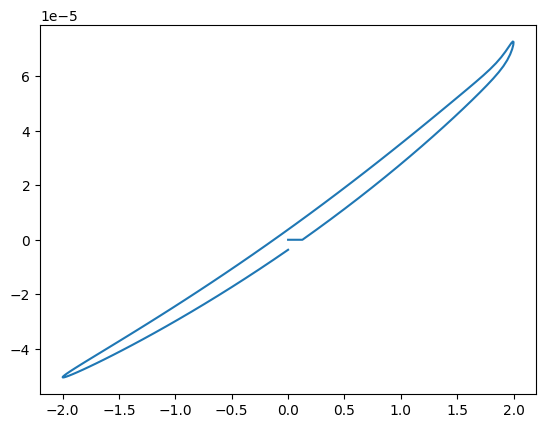

In [65]:
model = Model()
model.set_default()
model.set_puls_params(reprtition=1)
t, V = model.time_array, model.V

I = []
for i in range(len(t)):
    model.time_moment = i
    I.append(model.calculate())

plt.plot(V, I)
